In [15]:
import gensim
import gensim.downloader as model_api
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import sklearn.cluster as cluster
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix ,fowlkes_mallows_score, plot_confusion_matrix
from sklearn.preprocessing import Binarizer, MinMaxScaler, MaxAbsScaler, MultiLabelBinarizer, Normalizer, QuantileTransformer, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from statistics import mode
import umap
import umap.plot



<h1>Text Pre-processing</h>

In [59]:
df_original = pd.read_csv('data/data_reviews_clean.csv').drop('Unnamed: 0', axis = 1)

In [78]:
a = df_original.groupby('place_id').count()
a.loc[a['name'] == 5]

,name,text,author_name,author_url,language,rating,relative_time_description,time,profile_photo_url
place_id,,,,,,,,,
ChIJ-0xOFB4ZyUwRMtFpbXALQGA,5,5,5,5,5,5,5,5,5
ChIJ-1a_xVIXyUwREtsDg-jucWI,5,5,5,5,5,5,5,5,5
ChIJ-28nEWgNyUwRluQrGgQmYmQ,5,5,5,5,5,5,5,5,5
ChIJ-4inIXoayUwRrn_HOmg_pgM,5,5,5,5,5,5,5,5,5
ChIJ-7y3NZkGyUwR2G5vtIrSzdE,5,5,5,5,5,5,5,5,5
...,...,...,...,...,...,...,...,...,...
ChIJzYID92yoyUwROwmKO0S5mzU,5,5,5,5,5,5,5,5,5
ChIJzYx8APoOyUwRcBdwYvq13tk,5,5,5,5,5,5,5,5,5
ChIJzb5Vam8jyUwR21SNr5rlce8,5,5,5,5,5,5,5,5,5


In [62]:
df_original.nunique()

place_id                     1914
name                         1671
text                         9463
author_name                  8061
author_url                   8132
language                        3
rating                          5
relative_time_description      25
time                         9460
profile_photo_url            8132
dtype: int64

In [32]:
df = df_original.copy()#[:2000]

In [33]:
df = df[df['language']!= 'fr']

In [34]:
df = df[['text', 'rating']]

In [35]:
df = df.dropna()

In [36]:
df['text'].iloc[5]

'Good restaurant, family owned, decent choices... some of their items are much better than others... the customer courtesy can be improved and addresses.'

<h3>Stop Words</h3>

In [37]:
stop = list(stopwords.words('english'))
stop = sklearn.feature_extraction.text.ENGLISH_STOP_WORDS
stop = list(stop)
stop.extend(['just',
             'restaurant',
             'restaurants',
             'food',
             'don',
             've',
             'did',
             'got',
             'didn',
             'place',
             'went',
             'said',
             'try',
             'good',
             'delicious',
             'recommend',

])
stop_words = set(stop)

In [38]:
def plot_top_words(model, feature_names, n_top_words, n_topics, d, title):
    #Adapted code from sklearn documentation
    #https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py
    
    if n_topics <= 5:
        fig, axes = plt.subplots(1, n_topics, figsize=(30, 15), sharex=True)
    else:
        fig, axes = plt.subplots(2, n_topics, figsize=(30, 15), sharex=True)
        
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {d[topic_idx]}',
                     fontdict={'fontsize': 18})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()
    

In [87]:
def create_clusters(parameters):
    
    p = parameters.copy()
    
    df = p['data'].copy() 

    #Variables
    y_pred = None
    y_true = df['rating']
    word_features = df['text']
    vectorizer_id = p['vectorizer']['id']
    scaler_id = p['scaler']['id']
    reducer_id =  p['reducer_2d']['id']
    n_neighbors =  p['reducer_2d']['params']['n_neighbors']
    min_dist = p['reducer_2d']['params']['min_dist']
    model_id = p['model']['id']

    print(
    f'''
    vectorizer: {vectorizer_id}
    
    scaler: {scaler_id}
    
    reducer_2d: {reducer_id}
    n_neighbors: {n_neighbors}
    min_dist: {min_dist}
    
    model: {model_id}
    ''')
    
    
    #Word to vector
    if p['vectorizer']['id'] == 'tfidf':
        v_params = p['vectorizer']['params']
        vectorizer = TfidfVectorizer(min_df=v_params['min_df'],
                                     max_df = v_params['max_df'],
                                     stop_words=v_params['stop_words'])
    
    #Scaling 
    s_params = p['scaler']['params']
    if p['scaler']['id'] == 'QuantileTransformer':
        scaler = QuantileTransformer(random_state = s_params['random_state'])
        
    elif p['scaler']['id'] == 'MaxAbsScaler':
        scaler = MaxAbsScaler()
        
    elif p['scaler']['id'] == 'Normalizer':
        scaler = Normalizer()

    elif p['scaler']['id'] == 'Binarizer':
        scaler = Binarizer()
        
        
    #Model
    if p['model']['id'] == 'lda':
        m_params = p['model']['params']
        model = LatentDirichletAllocation(n_components = m_params['n_components'],
                                          random_state = m_params['random_state']) 
        
    elif p['model']['id'] == 'Random Forest Classifier':
        m_params = p['model']['params']
        model = DecisionTreeClassifier()   
      
    #Dimensionality reduction for graphical representation in 2D
    if p['reducer_2d']['id'] == 'umap':
        r_params = p['reducer_2d']['params']
        reducer = umap.UMAP(n_components = r_params['n_components'],
                            n_neighbors = r_params['n_neighbors'],
                            min_dist = r_params['min_dist'],
                            metric= r_params['metric'],
                            random_state = r_params['random_state'])

    #Fitting and Transformations
    vec_doc_matrix = vectorizer.fit_transform(word_features)
    vec_doc_matrix_scaled = scaler.fit_transform(vec_doc_matrix)
    
    if p['model']['type'] == 'supervised':
        if  p['model']['params']['reducer']['id'] == 'pca':
            X_train, X_test, y_train, y_test = train_test_split(vec_doc_matrix_scaled, y_true, test_size=0.33, random_state=42)
            n_components = p['model']['params']['reducer']['n_components']
            Xd_train = X_train.toarray()
            Xd_test = X_test.toarray()
            
            Xd_train= PCA(n_components).fit(Xd_train.T).components_.T
            Xd_test= PCA(n_components).fit(Xd_test.T).components_.T
            
        model.fit(Xd_train, y_train)
        y_train_predict = model.predict(Xd_train)
        y_test_predict = model.predict(Xd_test)
        
        
        #Dimensionality reduction for 2D plot
        Xd2_train = umap.UMAP(n_components=2, n_neighbors = 10, min_dist = 0.0,  metric='euclidean', random_state = 0).fit(X_train)
        Xd2_test = umap.UMAP(n_components=2, n_neighbors = 10, min_dist = 0.0,  metric='euclidean', random_state = 0).fit(X_test)

        #Model Results
        #Plots
        pred_plot = umap.plot.points(Xd2_train, labels = y_train_predict, theme='fire')
#         pred_plot.set_title('Plot of predicted labels with training data')
        plt. savefig('supervised training data') 
        true_plot = umap.plot.points(Xd2_train, labels= y_train, theme='fire')
#         true_plot.set_title('Plot of true labels with training data'.title())
        plt. savefig('review ratings training data') 
        pred_plot = umap.plot.points(Xd2_test, labels = y_test_predict, theme='fire')
        pred_plot.set_title('Plot of predicted labels with testing data')
        true_plot = umap.plot.points(Xd2_test, labels= y_test, theme='fire')
        true_plot.set_title('Plot of true labels with testing data'.title())
        #Report
        class_report_train = classification_report(y_train, y_train_predict)
        class_report_test = classification_report(y_test, y_test_predict)
        print(class_report_train)
        print(class_report_test)
        
        #Confusion Matrix
        fig, (ax1, ax2) = plt.subplots(1,2, figsize = (20, 10))
        plot_confusion_matrix(model, Xd_train, y_train, ax = ax1)
        ax1.set_title(f'Confusion Matrix Generated\n with {model_id} Model and Training Data')
        plot_confusion_matrix(model, Xd_test, y_test, ax = ax2)
        ax2.set_title(f'Confusion Matrix Generated\n with {model_id} Model and Testing Data')
        plt.show()
        
    elif p['model']['type'] == 'unsupervised' and p['model']['id'] == 'lda': 
        model.fit(vec_doc_matrix_scaled)
        topics = model.transform(vec_doc_matrix_scaled).argmax(axis = 1)
        
        #Dimensionality reduction for 2D plot
        emb = reducer.fit(vec_doc_matrix_scaled)  
    
        pred_labels = pd.Series(topics).value_counts().sort_values().index
        true_labels = df['rating'].value_counts().sort_values().index
        d = dict(zip(pred_labels , true_labels))

        df['topic'] = topics
        df['topic'] = df['topic'].map(d)
        
        feature_names = vectorizer.get_feature_names()
        y_pred = df['topic']
        n_top_words =  p['model']['params']['n_top_words']        
        num_topics = p['model']['params']['n_components']

        #Model Results
        #Plots
        pred_plot = umap.plot.points(emb, labels=df['topic'], theme='fire')
#         pred_plot.set_title('Plot of predicted reviewer ratings with unsupervised learning'.title())
        plt. savefig('Plot of predicted reviewer ratings') 
        true_plot = umap.plot.points(emb, labels=df['rating'], theme='fire')
#         true_plot.set_title('Plot of reviewer ratings from GOOGLE Place')
        plt. savefig('Plot of reviewer ratings') 
        plot_top_words(model, feature_names, n_top_words, num_topics, d, f'{num_topics} topics in {model_id} model')
        
        #Report
        class_report = classification_report(y_true, y_pred)
        fowlkes_score = fowlkes_mallows_score(y_true, y_pred)
        print(f'Classification report for {model_id} model')
        print(f'{classification_report(y_true, y_pred)}')
        print(f'\nFowlkes_mallows_score : {fowlkes_score}')

        #Confusion Matrix
        x_axis_labels = range(1,6)
        y_axis_labels = x_axis_labels
        conf_matrix = confusion_matrix(y_true, y_pred)
        ax = sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",xticklabels=x_axis_labels, yticklabels=y_axis_labels)
        ax.set_xlabel('Predicted label')
        ax.set_ylabel('True label')    
        ax.set_title(f'Confusion Matrix for {model_id} model')
    
        print(d)
        print(df)
        


    vectorizer: tfidf
    
    scaler: QuantileTransformer
    
    reducer_2d: umap
    n_neighbors: 10
    min_dist: 0.0
    
    model: lda
    


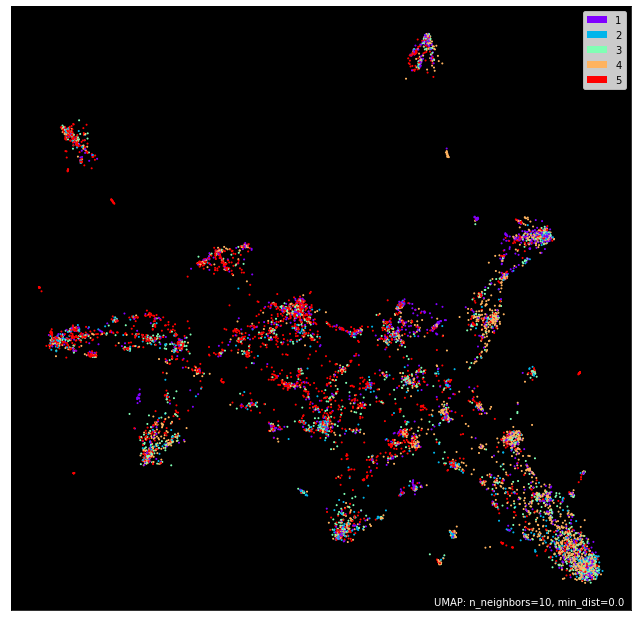

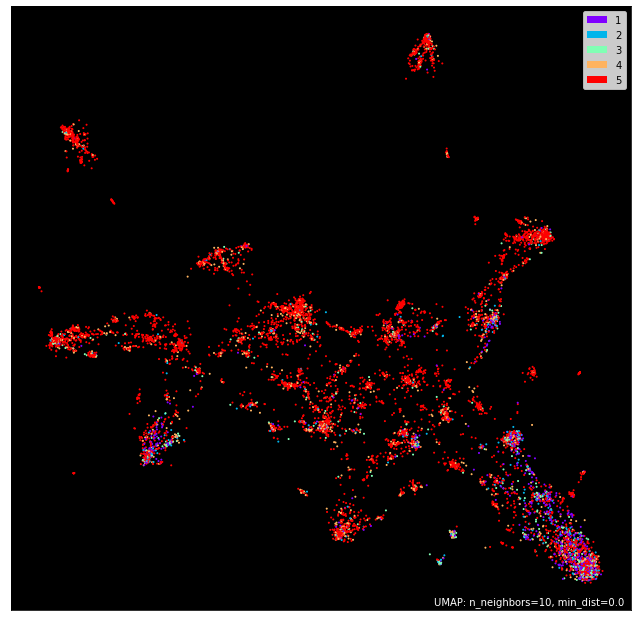

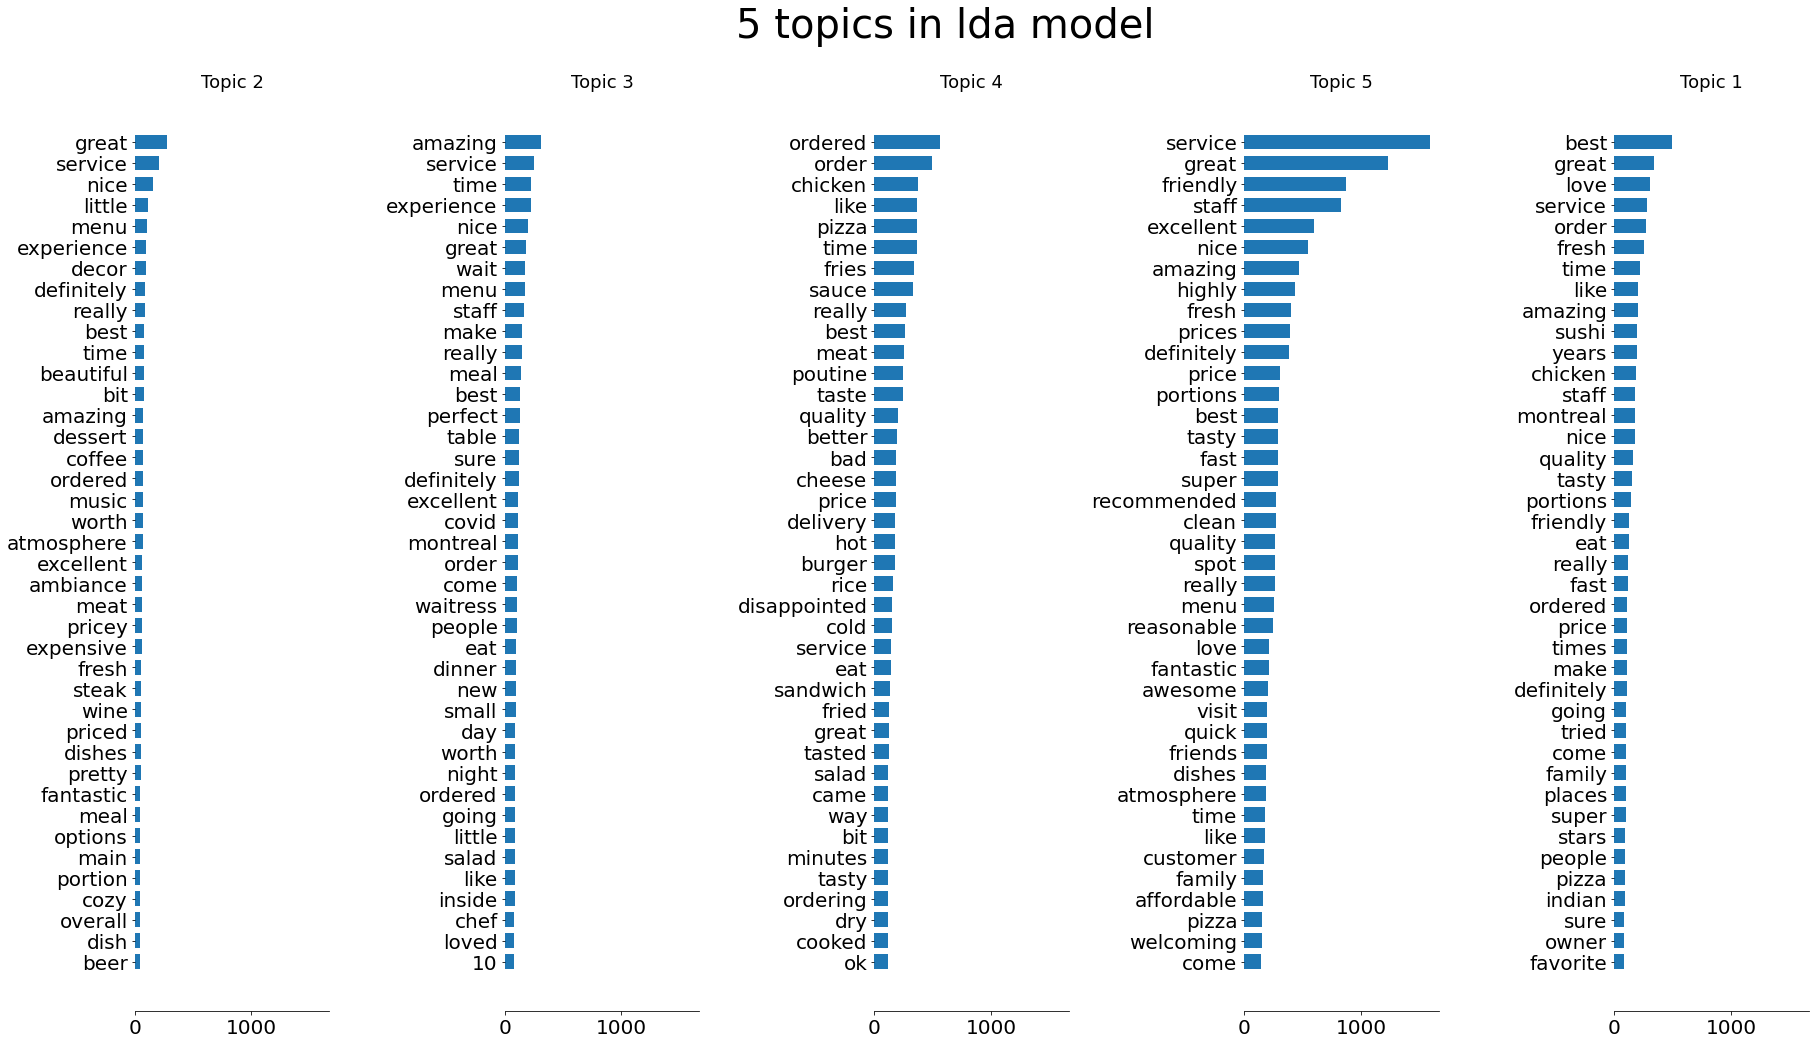

Classification report for lda model
              precision    recall  f1-score   support

           1       0.06      0.14      0.09       843
           2       0.03      0.06      0.04       388
           3       0.07      0.19      0.10       515
           4       0.14      0.27      0.19      1225
           5       0.87      0.40      0.55      6488

    accuracy                           0.34      9459
   macro avg       0.23      0.21      0.19      9459
weighted avg       0.62      0.34      0.42      9459


Fowlkes_mallows_score : 0.3854922171513161
{0: 2, 1: 3, 4: 1, 2: 4, 3: 5}
                                                   text  rating  topic
0     Staff is super friendly, owner is very involve...       4      2
1     A frequently visited restaurant for my family ...       5      1
2     The outdoor terrace was nice with kids (especi...       1      4
3     The Cape Cod Restaurant has adjusted nicely to...       4      5
4     Food is absolutely amazing. Amazing ser

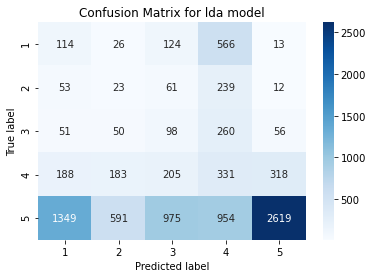

In [88]:
data = df

vectorizer = {
    'id': 'tfidf',
    'params' : {'min_df' : 2,
                'max_df' : 0.95,
                'stop_words' : stop_words}
}

scaler = {'id': 'QuantileTransformer',
          'params' :{'random_state' : 100}
         }

model  = {'id': 'lda',
          'type': 'unsupervised',
          'params' : {'n_components' : 5, 
                     'random_state' : 0,
                     'n_top_words' : 40}
         }

reducer_2d = {'id': 'umap',
              'params' : {'n_components' : 2, 
                          'n_neighbors' : 10,
                          'min_dist' : 0.0,
                          'metric': 'euclidean',
                          'random_state' : 0}
         } 

params = {'data' : data, 
          'vectorizer' : vectorizer,
          'scaler' : scaler,
          'model': model,
          'reducer_2d' : reducer_2d,
}

create_clusters(params)


    vectorizer: tfidf
    
    scaler: QuantileTransformer
    
    reducer_2d: umap
    n_neighbors: 10
    min_dist: 0.0
    
    model: Random Forest Classifier
    
              precision    recall  f1-score   support

           1       1.00      0.99      1.00       569
           2       1.00      1.00      1.00       267
           3       0.99      0.99      0.99       347
           4       0.99      0.99      0.99       810
           5       1.00      1.00      1.00      4344

    accuracy                           1.00      6337
   macro avg       1.00      0.99      1.00      6337
weighted avg       1.00      1.00      1.00      6337

              precision    recall  f1-score   support

           1       0.20      0.22      0.21       274
           2       0.06      0.09      0.07       121
           3       0.08      0.12      0.10       168
           4       0.13      0.18      0.15       415
           5       0.74      0.63      0.68      2144

    accuracy   

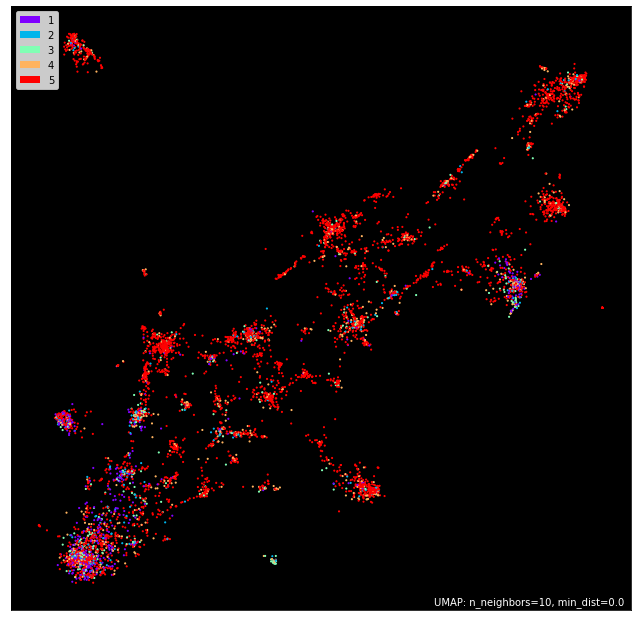

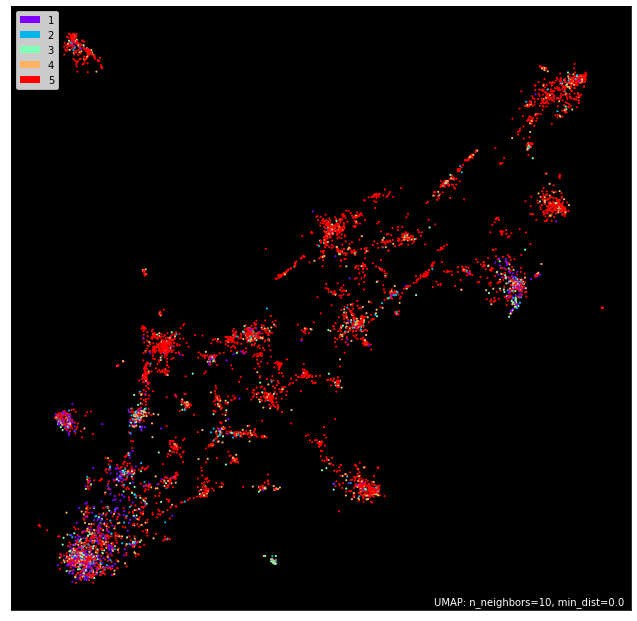

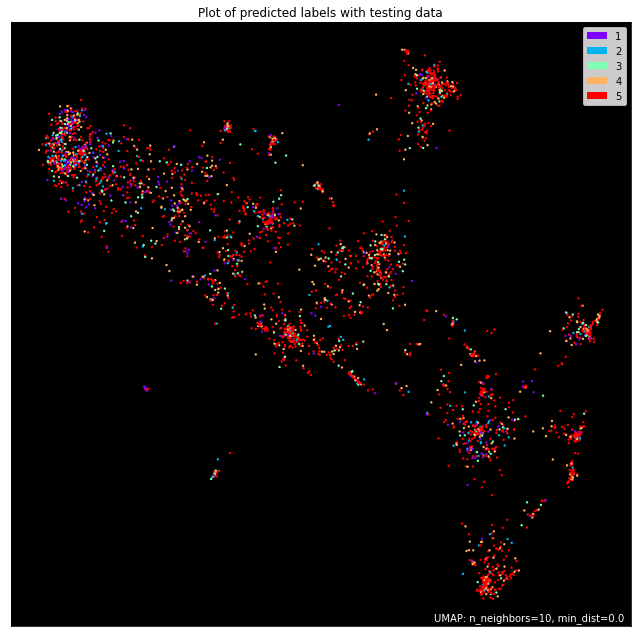

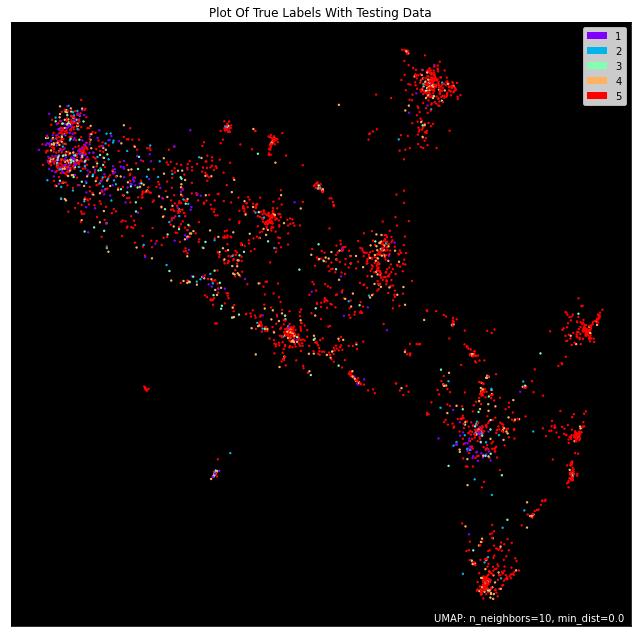

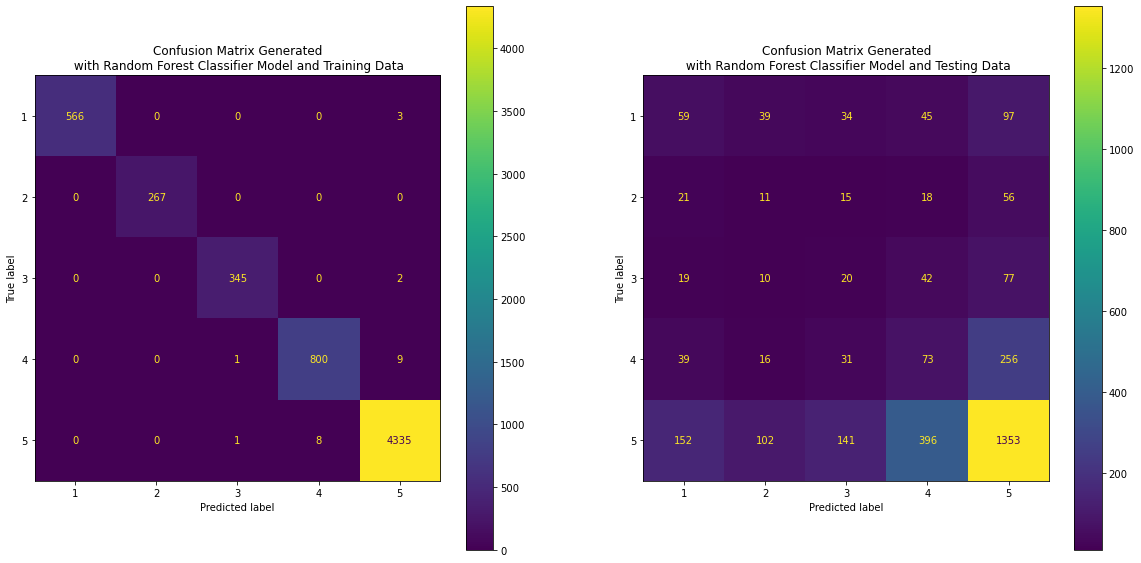

In [89]:
# scalers = ['Binarizer', 'Normalizer', 'MaxAbsScaler', 'QuantileTransformer']

data = df

vectorizer = {
    'id': 'tfidf',
    'params' : {'min_df' : 2,
                'max_df' : 0.95,
                'stop_words' : stop_words}
}

scaler = {'id': 'QuantileTransformer',
          'params' :{'random_state' : 100}
         }


model = {'id' : 'Random Forest Classifier',
         'type' : 'supervised',
         'params' : {
             'reducer' : {'id' : 'pca',
                         'n_components' : 200}
             
         }}

reducer_2d = {'id': 'umap',
              'params' : {'n_components' : 2, 
                          'n_neighbors' : 10,
                          'min_dist' : 0.0,
                          'metric': 'euclidean',
                          'random_state' : 0}
         } 

params = {'data' : data, 
          'vectorizer' : vectorizer,
          'scaler' : scaler,
          'model': model,
          'reducer_2d' : reducer_2d,
}

create_clusters(params)